<a href="https://colab.research.google.com/github/kyunghyuncho/ammi-2019-nlp/blob/master/01-day-LM/ngram_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling

## Goal: compute a probabilty distribution over all possible sentences:


## $$p(W) = p(w_1, w_2, ..., w_T)$$

## This unsupervised learning problem can be framed as a sequence of supervised learning problems:

## $$p(W) = p(w_1) * p(w_2|w_1) * ... * p(w_T|w_1, ..., w_{T-1})$$

## If we have N sentences, each of them with T words / tokens, then we want to max:

## $$log p(W) = \sum_{n = 1}^N \sum_{i=1}^{T} log p(w_i | w_{<i})$$




# N-gram language model

## Goal: estimate the n-gram probabilities using counts of sequences of n consecutive words

## Given a sequence of words $w$, we want to compute

##  $$P(w_i|w_{i−1}, w_{i−2}, …, w_{i−n+1})$$

## Where $w_i$ is the i-th word of the sequence.

## $$P(w_i|w_{i−n+1}, ..., w_{i−2}, w_{i−1}) = \frac{p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w_i)}{\sum_{w \in V} p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w)}$$

## Key Idea: We can estimate the probabilities using counts of n-grams in our dataset 


# Let's see this in Practice

In [17]:
# TODOs
#: implement the neural LM with concat instead of summation -- so that you have a fixed input etc.
# make a separate
# create some slides with pictures maybe explaining the model visualizations -- line by line
# get google cloud working
# make it work on gpu
# show them kenlm and how to use to do different stuff with it
# use the same sentences to generation and testing etc.
# explain perplexity
# ngram, ff, rnn, rnn+attention
# do sentence generation
# do long sentences
# compare different n-grams -- 2,3,more

### Install if needed

TODO: should we install as needed and import as needed or all at once?

In [18]:
# # run if you dont have it installed
# !pip install more_itertools
# !pip install spacy# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager\
# !python -m spacy download en_core_web_sm
# !

### Imports

In [101]:
import sys
sys.path.insert(0, "/home/roberta/ParlAI")
print(sys.path)


['/home/roberta/ParlAI', '/home/roberta/ParlAI', '/home/roberta/ParlAI', '/home/roberta/ammi-2019-nlp/01-day-LM', '/home/roberta/ammi-2019-nlp/01-day-LM', '/home/roberta/playground', '/home/roberta/general-value-function', '/home/roberta/general-value-function/baselines', '/home/roberta/general-value-function/mazebase', '/home/roberta/general-value-function/mazebase/mazebase', '/home/roberta/miniconda3/envs/ammi/lib/python37.zip', '/home/roberta/miniconda3/envs/ammi/lib/python3.7', '/home/roberta/miniconda3/envs/ammi/lib/python3.7/lib-dynload', '', '/home/roberta/miniconda3/envs/ammi/lib/python3.7/site-packages', '/home/roberta/miniconda3/envs/ammi/lib/python3.7/site-packages/IPython/extensions', '/home/roberta/.ipython']


In [293]:
import numpy as np
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy
import itertools
from operator import itemgetter 
from glob import glob
from tqdm import tqdm_notebook, tqdm
_tqdm = tqdm_notebook
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import more_itertools as mit  # not built-in package
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 
import pandas
import altair
from parlai.core.torch_agent import TorchAgent, Output


In [294]:
torch.manual_seed(1)


In [32]:
# # Create .txt files with the reviews

# with open('../data/amazon_reviews_clothing_train.txt', 'w') as f:
#     for review in train_reviews:
#         for token in review:
#             f.write("%s " % token) 
#         f.write("\n")
        
# with open('../data/amazon_reviews_clothing_test.txt', 'w') as f:
#     for review in test_reviews:
#         for token in review:
#             f.write("%s " % token) 
#         f.write("\n")
        
# with open('../data/amazon_reviews_clothing_valid.txt', 'w') as f:
#     for review in valid_reviews:
#         for token in review:
#             f.write("%s " % token) 
#         f.write("\n")

### Load Data from .txt Files

In [296]:
# Read data from .txt files and create lists of reviews

train_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_train.txt', 'r') as f:
    train_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     train_data.append(review.split())
    
test_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_test.txt', 'r') as f:
    test_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     test_data.append(review.split())
    
valid_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_valid.txt', 'r') as f:
    valid_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     valid_data.append(review.split())


In [297]:

type(train_data), len(train_data), \
type(train_data[0]), len(train_data[0]), \
type(train_data[0][0]), len(train_data[0][0])




(list, 222919, str, 184, str, 1)

In [298]:
train_data[0], train_data[0][0]


("this is a great tutu and at a really great price . it doesn ' t look cheap at all . i ' m so glad i looked on amazon and found such an affordable tutu that isn ' t made poorly . a + + ",
 't')

### Process the Data

In [299]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')               
punctuations = string.punctuation
# punctuations = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~' 
TAG_RE = re.compile(r'<[^>]+>') # get rid off HTML tags from the data

def remove_tags(text):
    return TAG_RE.sub('', text)

def lower_case(parsed):
    return [token.text.lower() for token in parsed] #and (token.is_stop is False)]

def remove_punc(parsed):
    return [token.text for token in parsed if (token.text not in punctuations)]

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)] #and (token.is_stop is False)]

def tokenize_dataset(dataset):
   # tokenize each sentence -- each tokenized sentence will be an element in token_dataset
    token_dataset = []
    # tokenize all words -- each token will be an item in all_tokens (in the order given by the list of sentences)
    all_tokens = []     # all the tokens -- 

    for sample in _tqdm(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
#         tokens = lower_case_remove_punc(sample)
        tokens = lower_case(sample)       # make words lower case
#         tokens = remove_punct(tokens)     # remove punctuation
        token_dataset.append(tokens)    
        all_tokens += tokens
        
    return token_dataset, all_tokens

In [300]:
punctuations, punctuations[0], \
type(punctuations), len(punctuations), type(punctuations[0]), 

('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', '!', str, 32, str)

In [301]:
TAG_RE

re.compile(r'<[^>]+>', re.UNICODE)

In [302]:
# TODO: for now only work with small subset of the data -- switch to all data later
train_data = train_data[:80]
test_data = test_data[:10]
valid_data = valid_data[:10]

In [303]:
type(train_data), type(train_data[0]), type(train_data[0][0])

(list, str, str)

In [304]:
# Tokenize the Datasets
# TODO: this takes a really long time !! why?
train_data_tokenized, all_tokens_train = tokenize_dataset(train_data)
test_data_tokenized, all_tokens_test = tokenize_dataset(test_data)
valid_data_tokenized, all_tokens_valid = tokenize_dataset(valid_data)


Let's look at the tokenized data!

In [305]:
# Number of All Tokens
len(all_tokens_train), all_tokens_train[0], \
len(train_data_tokenized), train_data_tokenized[0]

(14771,
 'this',
 80,
 ['this',
  'is',
  'a',
  'great',
  'tutu',
  'and',
  'at',
  'a',
  'really',
  'great',
  'price',
  '.',
  'it',
  'doesn',
  "'",
  't',
  'look',
  'cheap',
  'at',
  'all',
  '.',
  'i',
  "'",
  'm',
  'so',
  'glad',
  'i',
  'looked',
  'on',
  'amazon',
  'and',
  'found',
  'such',
  'an',
  'affordable',
  'tutu',
  'that',
  'isn',
  "'",
  't',
  'made',
  'poorly',
  '.',
  'a',
  '+',
  '+'])

#### Build the Vocabulary 


In [306]:
# Build a vocabulary using all the tokens found in train data (90% of most common ones)
voc = list(set(all_tokens_train))
print('Word vocabulary size: {} words'.format(len(voc)))        


Word vocabulary size: 2091 words


### CORPUS ANALYSIS (Train + Valid Data)

#### Number of Tokens in the Corpus Data


In [307]:
print("Number of All Tokens ", len(all_tokens_train))

Number of All Tokens  14771


In [308]:
print("Number of All UNIQUE Tokens ", len(voc))

Number of All UNIQUE Tokens  2091


#### Number of Sentences in the Train Data


In [309]:
print("Number of Sentences ", len(train_data_tokenized))

Number of Sentences  80


## N-grams

In [310]:
n = 3 # trigrams

### Function for padding the sentences with special markers sentence beginning and end, i.e. $<bos>$ and $<eos>$

In [311]:
def pad_sentences(input_list, n):
    result_list = []
    for l in input_list:
        padded = ["<bos>" for i in range((n - 1))] + l +["<eos>" for i in range((n - 1))]
        result_list.append(padded)
    return result_list

In [312]:
train_padded = pad_sentences(train_data_tokenized, n)
valid_padded = pad_sentences(valid_data_tokenized, n)
test_padded = pad_sentences(test_data_tokenized, n)

In [313]:
# train_padded[:2]

### Function for finding all N-grams

In [314]:
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append(list(zip(*[l[i:] for i in range(n)])))
    return result_list

In [159]:
# train_ngram[:2]

### Function for Getting N-gram counts for already tokenized data

In [315]:
def ngram_counts(data, n, frac_vocab=0.9):    
    all_train_tokens = list(mit.flatten(data))
    counted_tokens = Counter(all_train_tokens)
    max_vocab_size = int(frac_vocab * len(counted_tokens))

    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    
    return vocab, count

In [316]:
train_ngram = find_ngrams(train_padded, n)
vocab_trigram, count_trigram = ngram_counts(train_ngram, n)
vocab_trigram, count_trigram = ngram_counts(train_ngram, n)
vocab_ngram, count_ngram = ngram_counts(train_ngram, n)
# train_ngram

In [317]:
# vocab_ngram[:3], count_ngram[:3]

In [318]:
PAD_IDX = 0
UNK_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3

### Function for Getting N-gram Dict

In [319]:
def ngram_dict(vocab):
    PAD_IDX = 0
    UNK_IDX = 1 
    BOS_IDX = 2
    EOS_IDX = 3
    
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
    id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    token2id['<bos>'] = BOS_IDX 
    token2id['<eos>'] = EOS_IDX

    return id2token, token2id

In [320]:
id2token_ngram, token2id_ngram = ngram_dict(vocab_ngram)

In [321]:
id2token_ngram[:10], \
# token2id_ngram['<unk>'], token2id_ngram['<eos>'], token2id_ngram[('rosetta', 'stone')]

(['<pad>',
  '<unk>',
  '<bos>',
  '<eos>',
  ('.', '<eos>', '<eos>'),
  ('it', "'", 's'),
  ('.', '.', '.'),
  ('i', "'", 'm'),
  ('<bos>', '<bos>', 'i'),
  ('don', "'", 't')],)

In [322]:
random_token_id = random.randint(0, len(id2token_ngram) - 1)
random_token = id2token_ngram[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token_ngram[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id_ngram[random_token]))

Token id 10249 ; token (',', 'hello', ',')
Token (',', 'hello', ','); token id 10249


In [323]:
def _text2id(doc, token2id):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec, id2token):
    return [id2token[i] for i in vec]

In [324]:
def create_data_id(data, token2id):
    data_id = []
    for d in data:
        data_id.append(_text2id(d, token2id))
    return data_id

def create_data_id_merged(data, token2id, n):
    data_id_merged = []
    for d in data:
        for i in range(len(d) - n):
            data_id_merged.append((d[i:i+n], d[i+n]))
    return data_id_merged

In [325]:
n = 1
train_padded_uni = pad_sentences(train_data_tokenized, n)
train_unigram = find_ngrams(train_padded_uni, n)
vocab_unigram, count_unigram = ngram_counts(train_unigram, n)
id2token_unigram, token2id_unigram = ngram_dict(vocab_unigram)


In [326]:
n = 3
data_id = create_data_id(train_unigram, token2id_unigram)
data_id_merged = create_data_id_merged(data_id, token2id_unigram, n)

train_data_id = data_id
train_data_id_merged = data_id_merged

In [329]:
# valid_ngram = find_ngrams(valid_padded, n)
# valid_data_id = create_data_id(valid_ngram, token2id_ngram)
# valid_data_id_merged = create_data_id_merged(valid_data_id, token2id_ngramn, n)


In [330]:
# type(data_id), data_id[0]

In [331]:
# type(data_id_merged), data_id_merged[0]

In [334]:
# Function that combines all the aboce and goes from tokenized data to the ngram dataset
def create_id_dataset(data, n):
    padded_data = pad_sentences(data, n)
    ngram_data = find_ngrams(padded_data, n)
    
    vocab, count = ngram_counts(ngram_data, n)    
    id2token, token2id = ngram_dict(vocab)
    
    data_id = create_data_id(ngram_data, token2id)
    data_id_merged = create_data_id_merged(data_id, token2id, n)
    
    return data_id, data_id_merged

In [335]:
all_data_id, all_data_id_merged = create_id_dataset(train_data_tokenized, n)

In [336]:
# all_data_id[0], all_data_id_merged[0]


### Function for computing the probability of an n-gram

In [337]:
vocab_ngram[:10], count_ngram[:10]

((('.', '<eos>', '<eos>'),
  ('it', "'", 's'),
  ('.', '.', '.'),
  ('i', "'", 'm'),
  ('<bos>', '<bos>', 'i'),
  ('don', "'", 't'),
  ('!', '<eos>', '<eos>'),
  ('i', "'", 've'),
  ('.', 'i', "'"),
  ('you', "'", 're')),
 (59, 40, 33, 26, 23, 23, 14, 14, 13, 13))

In [338]:
def get_ngram_count(ngram, vocab, count):
    if ngram in vocab:
        ngram_idx = vocab.index(ngram)
        return count[ngram_idx] 
    else:
        return 0


In [339]:
c = get_ngram_count(('.', 'i'), vocab_ngram, count_ngram)
c

# c = get_ngram_count(('baby', 'panda'), vocab_ngram, count_ngram)
# c

0

In [340]:
c = get_ngram_count(('it', "'", 's'), vocab_ngram, count_ngram)
c


# c = get_ngram_count(('baby', 'panda', 'sweet'), vocab_ngram, count_ngram)
# c

40

### Function for computing the probability of a sentence

## N-gram Probabilities

## $$P(w|w_{−n}, ..., w_{−2}, w_{−1}) \approx \frac{c(w_{−n}, ..., w_{−2}, w_{−1}, w)}{\sum_{w \in V} c(w_{−n}, ..., w_{−2}, w_{−1}, w)}$$


In [341]:
def get_ngram_prob(ngram, vocab, count):
    c = get_ngram_count(ngram, vocab, count)
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
#             print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

## Bigram Probabilities

## $$p(w_i | w_{i-1}) = \frac{c(w_{i-1}, w_i)}{\sum_{w_i} c(w_{i-1}, w_i)} $$


In [342]:
p = get_ngram_prob(('rosetta', 'stone'), vocab_ngram, count_ngram)
p, 69/(69+2+2+1+1+1+1+1)

# p = get_ngram_prob(('i', 'am'), vocab_ngram, count_ngram)
# p

# p = get_ngram_prob(('it', "'", 's'), vocab_ngram, count_ngram)
# p

# p = get_ngram_prob(('i', "like", 'it'), vocab_ngram, count_ngram)
# p, 1/(2+1+1+1+1)

(0, 0.8846153846153846)

## Add-One Smoothing

In [351]:
def get_ngram_prob_add_one_smoothing(ngram, vocab, count):
    c = get_ngram_count(ngram, vocab, count) + 1
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
            print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    all_counts += len(voc)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [352]:
# TODO: show examples
p = get_ngram_prob(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram)
p


0

In [353]:
p = get_ngram_prob_add_one_smoothing(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram)
p


0.00047824007651841227

## Additive Smoothing

In [354]:
def get_ngram_prob_addditive_smoothing(ngram, vocab, count, delta=0.5):
    c = get_ngram_count(ngram, vocab, count) + delta*1
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
#             print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    all_counts += delta*len(voc)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [355]:
p = get_ngram_prob_addditive_smoothing(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram, delta=0.1)
p

0.0004782400765184122

### Linear Interpolation Smoothing

In [356]:
def get_ngram_prob_interpolation_smoothing(ngram, vocab, count, prev_vocab, prev_count, alpha=0.5):
    c = get_ngram_count(ngram, vocab, count)
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
#             print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    if all_counts > 0:
        prob_ngram = c / all_counts
    else:
        prob_ngram = 0
    
    prev_ngram = tuple(list(ngram[1:]))
    prev_c = get_ngram_count(prev_ngram, prev_vocab, prev_count)
#     print(prev_c)
    prev_all_counts = 0
    for prev_t in prev_vocab:
        if prev_t[:-1] == prev_ngram[:-1]:
#             print(prev_t, get_ngram_count(prev_t, prev_vocab, prev_count))
            prev_all_counts += get_ngram_count(prev_t, prev_vocab, prev_count)
    if prev_all_counts > 0:
        prob_prev_ngram = prev_c / prev_all_counts
    else:
        0
    return alpha*(prob_ngram) + (1-alpha)*prob_prev_ngram

In [357]:
train_padded = pad_sentences(train_data_tokenized, 3)
train_trigram = find_ngrams(train_padded, 3)
vocab_trigram, count_trigram = ngram_counts(train_trigram, 3)


train_padded = pad_sentences(train_data_tokenized, 2)
train_bigram = find_ngrams(train_padded, 2)
vocab_bigram, count_bigram = ngram_counts(train_bigram, 2)

train_padded = pad_sentences(train_data_tokenized, 1)
train_unigram = find_ngrams(train_padded, 1)
vocab_unigram, count_unigram = ngram_counts(train_unigram, 1)


### Smoothing: Linear Interpolation with Absolute Discounting

### $$p_{bi}(w|v) = max ({ \frac{N(v, w) - b_{bi}}{N(v)}, 0)  + b_{bi} \frac{V - N_0(v, \cdot)}{N(v)} p_{uni}(w) \large}$$

### $$p_{uni}(w) = max ({ \frac{N(w) - b_{uni}}{N}, 0)  + b_{uni} \frac{V - N_0(\cdot)}{N} \frac{1}{V}}$$

### $$b_{bi} = \frac{N_1(\cdot, \cdot)}{N_1(\cdot, \cdot) + 2*N_2(\cdot, \cdot)}$$

### $$b_{uni} = \frac{N_1(\cdot)}{N_1(\cdot) + 2*N_2(\cdot)}$$


### $$N_r(\cdot) = \sum_{w: N(w) = r} 1$$

### $$N_r(\cdot, \cdot) = \sum_{v, w: N(v, w) = r} 1$$

### $$N_r(v, \cdot) = \sum_{w: N(v, w) = r} 1$$

### V is the number of words in the vocabulary

### $N_r(\cdot, \cdot)$ and $N_r(\cdot)$  are the count-counts for bigrams and unigrams respectively $


In [358]:
def get_unigram_count(r):
    return np.sum([1 for i in range(len(vocab_unigram)) if count_unigram[i] == r])

def get_bigram_count(r):
    return np.sum([1 for i in range(len(vocab_bigram)) if count_bigram[i] == r])

def get_biunigram_count(r, token):
    cc = 0
    for other_token in vocab_unigram:
        bigram = tuple([token] + [other_token])
        if bigram in vocab_bigram:
            bigram_idx = vocab_bigram.index(bigram) 
            if count_bigram[bigram_idx] == r:
                cc += 1
                
#     for bigram in vocab_bigram:
#         print(token, bigram[0])
#         if token == bigram[0]:
#             bigram_idx = vocab_bigram.index(bigram) 
#             if count_bigram[bigram_idx] == r:
#                 cc += 1
    return cc

def get_b_bi():
    bbi = get_bigram_count(1) / (get_bigram_count(1) + 2 * get_bigram_count(2))
    return bbi
    
def get_b_uni():
    buni = get_unigram_count(1) / (get_unigram_count(1) + 2 * get_unigram_count(2))
    return buni

def get_p_uni(w):
    if w in vocab_unigram:
        w_idx = vocab_unigram.index(w)
        N_w = count_unigram[w_idx]
    else:
        N_w = 0
        
    b_uni = get_b_uni()
    
    W = len(voc)
    N_0 = get_unigram_count(0)
    
    
    N = len(all_tokens_train) # TODO: double check the meaning of N 
    
    p_uni = max((N_w - b_uni / N), 0) + b_uni * (W - N_0) / N * 1 / W
    
    return p_uni

def get_p_bi(w, v):   # w given v
    if tuple([v] + [w]) in vocab_bigram:
        vw_idx = vocab_bigram.index(tuple([v] + [w]))
        N_vw = count_bigram[vw_idx]
    else:
        N_vw = 0
        
    if tuple([v]) in vocab_unigram:
        v_idx = vocab_unigram.index(tuple([v]))
        N_v = count_unigram[v_idx]
    else:
        N_v = 0  
        
    b_bi = get_b_bi()
    b_uni = get_b_uni()
    
    p_uni = get_p_uni(tuple([w]))
    
    W = len(voc)
    N_0 = get_biunigram_count(0, v)
    
    
    p_bi =  max((N_vw - b_bi) / N_v,  0) + \
         b_bi * (W - N_0) / N_v * p_uni
    
    return p_bi
        

In [359]:
x = 'stone'
y = 'rosetta'

z = get_p_bi(y, x)
z

1744.7693023255813

## Bigram Probabilities

### Let's check that the probabilities sum up to one
### $$\sum_w p_{bi}(w|v) = \sum_w p_{uni}(w) = 1$$



## Bigram LM
##  $$p(s) = \prod_{i = 1} ^ {N + 1} p(w_i | w_{i-1})$$

### Likelihood of a Sentence

In [343]:
def get_prob_sentence(sentence, vocab, count):
    padded_sentence = pad_sentences(sentence, n)  # needs a list
#     print(padded_sentence)
    ngram_sentence = find_ngrams(padded_sentence, n)[0] # only one element in list
#     print(ngram_sentence)
    prob = 1
    for ngram in ngram_sentence:
        prob_ngram = get_ngram_prob(ngram, vocab, count)
#         print(ngram, prob_ngram)
        prob *= prob_ngram
    return prob

In [344]:
sentence = [train_data_tokenized[0]]
# sentence = [['this', 'is', 'a', 'great', 'tutu']]
print(sentence)
ps = get_prob_sentence(sentence, vocab_ngram, count_ngram)
ps

[['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', '.', 'it', 'doesn', "'", 't', 'look', 'cheap', 'at', 'all', '.', 'i', "'", 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', "'", 't', 'made', 'poorly', '.', 'a', '+', '+']]


4.0055998183675866e-17

### Examples
### Bigram LM: $$ p(i \; love \; this \; light) = p(i|\cdot) \; p(love|i)\;  p(this|love)\;  p(light|this) \\
\approx \frac{c(i, \cdot)}{\sum_w c(\cdot, \; w)} \; \frac{c(love, i)}{\sum_wc(i, \; w)}\;  \frac{c(this, love)}{\sum_wc(love, \;w)}\;  \frac{c(light, this)}{\sum_wc(this, \;w)}$$ 

### Trigram LM: $$ p(i \; love \; this  \;light) = p(i|\cdot, \cdot) \; p(love|\cdot, i) \; p(this|i, love)\;  p(light|love, this)$$ 



### Another Example -- where this approach usually fails

### Bigram LM: $$ p(john \; went \; to \; the \; moon) = p(john|\cdot) p(went|john) p(to|went) p(the|to) p(moon|the)$$ 

### Trigram LM: $$ pp(john \; went \; to \; the \; moon = p(john|\cdot, \cdot) p(went|\cdot, john) p(to|john, went) p(the|went, to) p(moon|to, the)$$ 



In [345]:
def get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=False):
    pd = [0 for v in voc]
    for idx, token in enumerate(voc):
#         print("token: ", token)
#         print("prev ngram: ", prev_tokens)
#         print("both: ", tuple(list(prev_tokens) + [token]))
#         print("")
        token_ngram = tuple(list(prev_tokens) + [token])
        pd[idx] = get_ngram_prob(token_ngram, vocab_ngram, count_ngram)
#         if pd[idx] > 0 and print_nonzero_probs:
#             print(token_ngram, " ", pd[idx])
    return pd

In [346]:
# prob distr for the word following prev_tokens (i.e. tutu) 
# over all the words in the vocabulary 

# prev_tokens = train_data_tokenized[0][4] #[0]
prev_tokens = vocab_ngram[3][1:] #[0]   # need frmo 1 on so that this is a correct prev token
print(prev_tokens)
pd = get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=True)
sum(pd)#, pd

("'", 'm')


1.0000000000000002

In [347]:
def sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=False):
    pd = get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=print_nonzero_probs)
    idx_next_token = np.random.choice(len(voc), 1, p=pd)[0]
    return voc[idx_next_token]
    

In [348]:
print(prev_tokens)
next_token = sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=True)
next_token

("'", 'm')


'not'

### Sentence Generation

In [349]:
def generate_sentence(num_tokens, vocab_ngram, count_ngram, voc, n):
    sentence = []
    prev_tokens = tuple(['<bos>'] * (n - 1))
#     print(prev_tokens)
    for i in range(num_tokens):
        next_token = sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc)
#         print(i, next_token)
#         print(i, prev_tokens[1:])
        prev_tokens = tuple(list(prev_tokens[1:]) + [next_token])
#         print(i, prev_tokens)
        sentence.append(next_token)
        print(' '.join(sentence))
    return ' '.join(sentence)

In [350]:
num_tokens = 5
generated_sentence = generate_sentence(num_tokens, vocab_ngram, count_ngram, voc, n)
generated_sentence

# TODO: make this owkr for general ngram -- double check that it works

never
never having
never having studied
never having studied italian
never having studied italian before


'never having studied italian before'

In [360]:
# TODO: compute the sums
# show rank for each word in a sentence
# explain perplexity 

### Log-Likelihood
### $LL = \sum_{k=1}^{K} \sum_{n=1}^{N_k + 1} log p_{bi}(w_{k,n} | w_{k,n-1})$

### Perplexity

### $PP = exp(-\frac{LL}{\sum_k(N_k + 1)})$

In [361]:
def get_perplexity(test_sentences, vocab_ngram, count_ngram):
    ll = 0
    num_tokens = 0
    for s in (test_sentences):
        ll += get_prob_sentence([s], vocab_ngram, count_ngram)
        num_tokens += len(s) + 1

    ppl = np.exp(-ll/num_tokens)
    return ppl

In [362]:
ppl_test = get_perplexity(test_data_tokenized, vocab_ngram, count_ngram)
ppl_valid = get_perplexity(valid_data_tokenized, vocab_ngram, count_ngram)
ppl_train = get_perplexity(train_data_tokenized, vocab_ngram, count_ngram)


In [363]:
ppl_test, ppl_valid, ppl_train
# TODO check whether this makes sense -- maybe it seems too good?

(1.0, 1.0, 0.9999999993885841)

#### Let's look at some examples and see if they make sense

# Neural Language Modeling

## Make a PyTorch Dataset out of our set of dicts

In [373]:
class AmazonDataset(Dataset):
    def __init__(self, data_list, max_inp_length=None, cuda=True):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        for (i, t) in tqdm_notebook(self.data):
            if cuda:
                self.data_tensors.append((torch.LongTensor(i[:self.max_len]).cuda(), \
                                            torch.LongTensor([t]).cuda()))
            else:
                self.data_tensors.append((torch.LongTensor(i[:self.max_len]), \
                                          torch.LongTensor([t])))
                
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        
        return inp, tgt, len(inp)

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-1]
    batch_list = []
    target_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch

In [374]:
def create_data_id(data, token2id):
    data_id = []
    for d in data:
        data_id.append(_text2id(d, token2id))
    return data_id

def create_data_id_merged(data, token2id, n):
    data_id_merged = []
    for d in data:
        for i in range(len(d) - n):
            data_id_merged.append((d[i:i+n], d[i+n]))
    return data_id_merged

n = 1
train_padded_uni = pad_sentences(train_data_tokenized, n)
train_unigram = find_ngrams(train_padded_uni, n)
train_vocab_unigram, train_count_unigram = ngram_counts(train_unigram, n)
train_id2token_unigram, train_token2id_unigram = ngram_dict(train_vocab_unigram)

n = 1
valid_padded_uni = pad_sentences(valid_data_tokenized, n)
valid_unigram = find_ngrams(valid_padded_uni, n)
valid_vocab_unigram, count_unigram = ngram_counts(valid_unigram, n)
valid_id2token_unigram, valid_token2id_unigram = ngram_dict(valid_vocab_unigram)

N = 10
train_data_id = create_data_id(train_unigram, train_token2id_unigram)
train_data_id_merged = create_data_id_merged(train_data_id, train_token2id_unigram, N)

valid_data_id = create_data_id(valid_unigram, valid_token2id_unigram)
valid_data_id_merged = create_data_id_merged(valid_data_id, valid_token2id_unigram, N)


In [375]:
train_dataset = AmazonDataset(train_data_id_merged, max_inp_length=None, cuda=True)
train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

valid_dataset = AmazonDataset(valid_data_id_merged, max_inp_length=None, cuda=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

RuntimeError: CUDA error: device-side assert triggered

In [368]:
train_dataset[0], train_dataset[0][0].shape, \
valid_dataset[0], valid_dataset[0][0].shape

RuntimeError: CUDA error: device-side assert triggered

## Model

In [369]:
class BagOfNGrams(nn.Module):
    def init_layers(self):
        for l in self.layers:
            if getattr(l, 'weight', None) is not None:
                torch.nn.init.xavier_uniform_(l.weight)
    
    def __init__(self, vocab_size, emb_dim=300, hidden_size=256, out_size=128, reduce='sum', nlayers=2, activation='ReLU', dropout=0.1, batch_norm=False):
        super(BagOfNGrams, self).__init__()
       
        self.emb_dim = emb_dim
        self.reduce = reduce
        self.nlayers = nlayers
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.activation = getattr(nn, activation)
        
        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode=reduce)
        if batch_norm is True:
            self.batch_norm = nn.BatchNorm1d(self.emb_dim)
        self.layers = nn.ModuleList([nn.Linear(self.emb_dim, self.hidden_size)])
        self.layers.append(self.activation())
        self.layers.append(nn.Dropout(p=dropout))
        
        for i in range(self.nlayers-2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(self.activation())
            self.layers.append(nn.Dropout(p=dropout)) 
        self.layers.append(nn.Linear(self.hidden_size, self.out_size))
        self.init_layers()
    
    def forward(self, x):
        postemb = self.embedding(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(postemb)
        else:
            x = postemb
        for l in self.layers:
            x = l(x)
        
        return x

model = BagOfNGrams(len(train_id2token_unigram), emb_dim=300, hidden_size=256, out_size=128, activation='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
model.cuda()

RuntimeError: CUDA error: device-side assert triggered

In [370]:
class DecoderMLP(nn.Module):
    """Generates a token in response to context."""

    def __init__(self, input_size=128, output_size=1024, hidden_size=256):
        """Initialize decoder.
        :param input_size: size of embedding
        :param output_size: size of vocabulary
        :param hidden_size: size of the linear layers
        """
        super().__init__()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        """Return encoded state.
        :param input: batch_size x 1 tensor of token indices.
        :param hidden: past (e.g. encoder) hidden state
        """
        emb = self.embedding(input)
        rel = F.relu(emb)
        output = self.linear(rel)
        scores = self.softmax(self.out(output))
        return scores
    

In [371]:
class seq2seq(nn.Module):
    def __init__(self, bag_of_ngrams, decoder, lr = 1e-3, use_cuda = True, 
                        hiddensize = 128, numlayers = 2, target_lang = None, longest_label = 20, 
                        clip = 0.3):
        super(seq2seq, self).__init__()

        device = torch.device("cuda" if (torch.cuda.is_available() and use_cuda) else "cpu")
        self.device = device;
        self.bag_of_ngrams = bag_of_ngrams.to(device);
        self.decoder = decoder.to(device)

        self.target_lang = target_lang;

        self.bl = bleu_score.BLEU_SCORE()

        # set up the criterion
        self.criterion = nn.NLLLoss()

        self.optims = {
             'nmt': optim.SGD(self.parameters(), lr=lr, nesterov=True, momentum = 0.99)
        }

        self.scheduler = {};
        for x in self.optims.keys():
            self.scheduler[x] = ReduceLROnPlateau(self.optims[x], mode = 'max', min_lr=1e-4,  patience=0, verbose = True);

        self.longest_label = longest_label
        self.hiddensize = hiddensize
        self.numlayers = numlayers
        self.clip = clip;
        self.START = torch.LongTensor([global_variables.SOS_token]).to(device)
        self.END_IDX = global_variables.EOS_token;


    def zero_grad(self):
        """Zero out optimizer."""
        for optimizer in self.optims.values():
            optimizer.zero_grad()

    def update_params(self):
        """Do one optimization step."""
        if self.clip is not None:
            torch.nn.utils.clip_grad_norm_(self.bag_of_ngrams.parameters(), self.clip)
            torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), self.clip)
        for optimizer in self.optims.values():
            optimizer.step()

    def scheduler_step(self, val_bleu):
        for scheduler in self.scheduler.values():
            scheduler.step(val_bleu)


    def v2t(self, vector):
        """Convert vector to text.
        :param vector: tensor of token indices.
            1-d tensors will return a string, 2-d will return a list of strings
        """
        if vector.dim() == 1:
            output_tokens = []
            # Remove the final END_TOKEN that is appended to predictions
            for token in vector:
                if token == self.END_IDX:
                    break
                else:
                    output_tokens.append(token)
            return self.target_lang.vec2txt(output_tokens)

        elif vector.dim() == 2:
            return [self.v2t(vector[i]) for i in range(vector.size(0))]
        raise RuntimeError('Improper input to v2t with dimensions {}'.format(
            vector.size()))
        
    def train_step(self, data, labels):
        """Train model to produce ys given xs.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return estimated responses, with teacher forcing on the input sequence
        (list of strings of length batchsize).
        """
        xs = data
        ys = labels
        
        if xs is None:
            return
        xs = xs.to(self.device)
        ys = ys.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        loss = 0
        self.zero_grad()
        self.bag_of_ngrams.train()
        self.decoder.train()
        target_length = ys.size(1)
        # save largest seen label for later
        self.longest_label = max(target_length, self.longest_label)

        _encoder_output, encoder_hidden = self.bad_ngrams(xs)

        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                      encoder_hidden)

        scores = decoder_output.view(-1, decoder_output.size(-1))
        loss = self.criterion(scores, ys.view(-1))
        loss.backward()
        self.update_params()

        _max_score, predictions = decoder_output.max(2)
        return self.v2t(predictions), loss.item() 

    def eval_step(self, data, labels):
        """Generate a response to the input tokens.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return predicted responses (list of strings of length batchsize).
        """
        xs = data

        if xs is None:
            return

        xs = xs.to(self.device)

        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        # just predict
        self.bag_of_ngrams.eval()
        self.decoder.eval()
        _encoder_output = self.bag_of_ngrams(xs)

        predictions = []
        done = [False for _ in range(bsz)]
        total_done = 0
        decoder_input = starts

        for _ in range(self.longest_label):
            # generate at most longest_label tokens
            decoder_output = self.decoder(decoder_input)
            _max_score, preds = decoder_output.max(2)
            predictions.append(preds)
            decoder_input = preds  # set input to next step

            # check if we've produced the end token
            for b in range(bsz):
                if not done[b]:
                    # only add more tokens for examples that aren't done
                    if preds[b].item() == self.END_IDX:
                        # if we produced END, we're done
                        done[b] = True
                        total_done += 1
            if total_done == bsz:
                # no need to generate any more
                break
        predictions = torch.cat(predictions, 1)
        return self.v2t(predictions)

In [372]:
bag_of_ngrams = BagOfNGrams(len(train_id2token_unigram), emb_dim=300, hidden_size=256, out_size=128, activation='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
decoder = DecoderMLP(input_size=128, output_size=len(train_id2token_unigram), hidden_size=256)
model = seq2seq(bag_of_ngrams, decoder)
for epoch in range(num_epochs):
    for i, (data, labels) in _tqdm(enumerate(eval_loader)):
        model.eval_step(data, labels)
    for i, (data, labels) in _tqdm(enumerate(train_loader)):
        model.train_step(data, labels)


RuntimeError: CUDA error: device-side assert triggered

In [282]:
learning_rate = 0.01
num_epochs=100
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
for epoch in range(num_epochs):
    for i, (data, labels) in _tqdm(enumerate(train_loader)): 
        data.cuda()
        labels.cuda()
        model.cuda()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
#         print(loss.item())
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 10 == 0 and epoch > 0:
        print("Epoch {}: ".format(epoch), loss.item())
#         val_acc = test_model(loader=valid_loader, model=model)
#         print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
#                            epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))
        

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1549633347309/work/aten/src/THC/THCGeneral.cpp:405

In [257]:
class ExampleSeq2seqAgent(TorchAgent):
    """Agent which takes an input sequence and produces an output sequence.
    This model is based on Sean Robertson's `seq2seq tutorial
    <http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html>`_.
    """

    @classmethod
    def add_cmdline_args(cls, argparser):
        """Add command-line arguments specifically for this agent."""
        super(ExampleSeq2seqAgent, cls).add_cmdline_args(argparser)
        agent = argparser.add_argument_group('Seq2Seq Arguments')
        agent.add_argument('-hs', '--hiddensize', type=int, default=128,
                           help='size of the hidden layers')
        agent.add_argument('-esz', '--embeddingsize', type=int, default=128,
                           help='size of the token embeddings')
        agent.add_argument('-nl', '--numlayers', type=int, default=2,
                           help='number of hidden layers')
        agent.add_argument('-lr', '--learningrate', type=float, default=1,
                           help='learning rate')
        agent.add_argument('-dr', '--dropout', type=float, default=0.1,
                           help='dropout rate')
        agent.add_argument('--gpu', type=int, default=-1,
                           help='which GPU device to use')
        agent.add_argument('-rf', '--report-freq', type=float, default=0.001,
                           help='Report frequency of prediction during eval.')
        agent.add_argument('-rf', '--report-freq', type=float, default=0.001,
                           help='Report frequency of prediction during eval.')
        ExampleSeq2seqAgent.dictionary_class().add_cmdline_args(argparser)
        return agent

    def __init__(self, opt, shared=None):
        """Initialize example seq2seq agent.
        :param opt: options dict generated by parlai.core.params:ParlaiParser
        :param shared: optional shared dict with preinitialized model params
        """
        super().__init__(opt, shared)

        self.id = 'Seq2Seq'

        if not shared:
            # set up model from scratch
            hsz = opt['hiddensize']
            nl = opt['numlayers']
            act = opt['activation']
            
            self.bag_of_words = BagOfNGrams(len(train_id2token_unigram), emb_dim=30, hidden_size=hsz, activation=act, nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)

            # encoder captures the input text
            self.encoder = EncoderRNN(len(self.dict), hsz, nl)
            # decoder produces our output states
            self.decoder = DecoderRNN(len(self.dict), hsz, nl)

            if self.use_cuda:  # set in parent class
                self.encoder.cuda()
                self.decoder.cuda()

            if opt.get('numthreads', 1) > 1:
                self.encoder.share_memory()
                self.decoder.share_memory()
        elif 'encoder' in shared:
            # copy initialized data from shared table
            self.encoder = shared['encoder']
            self.decoder = shared['decoder']

        # set up the criterion
        self.criterion = nn.NLLLoss()

        # set up optims for each module
        lr = opt['learningrate']
        self.optims = {
            'encoder': optim.SGD(self.encoder.parameters(), lr=lr),
            'decoder': optim.SGD(self.decoder.parameters(), lr=lr),
        }

        self.longest_label = 1
        self.hiddensize = opt['hiddensize']
        self.numlayers = opt['numlayers']
        self.START = torch.LongTensor([self.START_IDX])
        if self.use_cuda:
            self.START = self.START.cuda()

        self.reset()

    def zero_grad(self):
        """Zero out optimizer."""
        for optimizer in self.optims.values():
            optimizer.zero_grad()

    def update_params(self):
        """Do one optimization step."""
        for optimizer in self.optims.values():
            optimizer.step()

    def share(self):
        """Share internal states."""
        shared = super().share()
        shared['encoder'] = self.encoder
        shared['decoder'] = self.decoder
        return shared

    def v2t(self, vector):
        """Convert vector to text.
        :param vector: tensor of token indices.
            1-d tensors will return a string, 2-d will return a list of strings
        """
        if vector.dim() == 1:
            output_tokens = []
            # Remove the final END_TOKEN that is appended to predictions
            for token in vector:
                if token == self.END_IDX:
                    break
                else:
                    output_tokens.append(token)
            return self.dict.vec2txt(output_tokens)
        elif vector.dim() == 2:
            return [self.v2t(vector[i]) for i in range(vector.size(0))]
        raise RuntimeError('Improper input to v2t with dimensions {}'.format(
            vector.size()))

    def vectorize(self, *args, **kwargs):
        """Call vectorize without adding start tokens to labels."""
        kwargs['add_start'] = False
        return super().vectorize(*args, **kwargs)

    def train_step(self, batch):
        """Train model to produce ys given xs.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return estimated responses, with teacher forcing on the input sequence
        (list of strings of length batchsize).
        """
        xs, ys = batch.text_vec, batch.label_vec
        if xs is None:
            return
        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        loss = 0
        self.zero_grad()
        self.encoder.train()
        self.decoder.train()
        target_length = ys.size(1)
        # save largest seen label for later
        self.longest_label = max(target_length, self.longest_label)

        _encoder_output, encoder_hidden = self.encoder(xs)

        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                      encoder_hidden)

        scores = decoder_output.view(-1, decoder_output.size(-1))
        loss = self.criterion(scores, ys.view(-1))
        loss.backward()
        self.update_params()

        _max_score, predictions = decoder_output.max(2)
        return Output(self.v2t(predictions))

    def eval_step(self, batch):
        """Generate a response to the input tokens.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return predicted responses (list of strings of length batchsize).
        """
        xs = batch.text_vec
        if xs is None:
            return
        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        # just predict
        self.encoder.eval()
        self.decoder.eval()
        _encoder_output, encoder_hidden = self.encoder(xs)

        predictions = []
        done = [False for _ in range(bsz)]
        total_done = 0
        decoder_input = starts
        decoder_hidden = encoder_hidden

        for _ in range(self.longest_label):
            # generate at most longest_label tokens
            decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                          decoder_hidden)
            _max_score, preds = decoder_output.max(2)
            predictions.append(preds)
            decoder_input = preds  # set input to next step

            # check if we've produced the end token
            for b in range(bsz):
                if not done[b]:
                    # only add more tokens for examples that aren't done
                    if preds[b].item() == self.END_IDX:
                        # if we produced END, we're done
                        done[b] = True
                        total_done += 1
            if total_done == bsz:
                # no need to generate any more
                break
        predictions = torch.cat(predictions, 1)
        return Output(self.v2t(predictions))

## Loss and Optimizer


In [118]:
learning_rate = 0.1
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
#optimizer = torch.optim.Adagrad(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Testing 

In [119]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

## Training

In [121]:
train_losses = []
num_epochs=20
for epoch in range(num_epochs):
    for i, (data, labels) in _tqdm(enumerate(train_loader)): 
        if i < 5:
            print("data ", data)
            print("labels ", labels)
        data.cuda()
        labels.cuda()
        model.cuda()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.view(-1), labels.float().view(-1))
        loss.backward()
        print(loss.item())
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 1 == 0 and epoch > 0:
        val_acc = test_model(loader=valid_loader, model=model)
        print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))
        

data  tensor([[   8,   63,    1,  ...,    0,    0,    0],
        [  62, 1752, 1753,  ...,    0,    0,    0],
        [  98, 3294, 3295,  ...,    0,    0,    0],
        ...,
        [1055, 1056, 1057,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20,    1,    1,  ...,    0,    0,    0],
        [   8,  373,  156,  ...,    0,    0,    0],
        [  98, 2926, 2927,  ...,    0,    0,    0],
        ...,
        [   8,  373, 9000,  ...,    0,    0,    0],
        [   8,    1,    1,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[ 362,  363, 2301,  ...,    0,    0,    0],
        [  62, 2323, 2324,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        ...,
        [   8,    1,    1,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [   8, 6962, 6963,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  112,   11,  ...,    0,    0,    0],
        [   8,    1,    1,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0],
        ...,
        [   8, 6962, 6963,  ...,    0,    0,    0],
        [ 344, 5627, 5628,  ...,    0,    0,    0],
        [ 330,  331,  942,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   1,    1,    1,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        [6477, 6478, 6479,  ...,    0,    0,    0],
        ...,
        [  62,  255,    1,  ...,    0,    0,    0],
        [ 785,  786,  787,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  112,   11,  ...,    0,    0,    0],
        [   8,  613,  614,  ...,    0,    0,    0],
        [  20,  314, 1463,  ...,    0,    0,    0],
        ...,
        [   8,   63,    1,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20,  253,    1,  ...,    0,    0,    0],
        [2116, 2117, 2118,  ...,    0,    0,    0],
        [  98, 3294, 3295,  ...,    0,    0,    0],
        ...,
        [   8,  112,   11,  ...,    0,    0,    0],
        [  98, 2209, 2210,  ...,    0,    0,    0],
        [  62,  255,    1,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  98, 2926, 2927,  ...,    0,    0,    0],
        [6477, 6478, 6479,  ...,    0,    0,    0],
        [  62, 2323, 2324,  ...,    0,    0,    0],
        ...,
        [   8, 1295, 1296,  ...,    0,    0,    0],
        [   8,  373, 9000,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[1055, 1056, 1057,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0],
        [  20, 2020, 2021,  ...,    0,    0,    0],
        ...,
        [  98, 4207,   14,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0],
        [  20,  314, 1463,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[1055, 1056, 1057,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0],
        [   8,  613,  614,  ...,    0,    0,    0],
        ...,
        [1590, 1591, 1592,  ...,    0,    0,    0],
        [  20,    1,    1,  ...,    0,    0,    0],
        [   8,  752, 7714,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8, 2354, 2355,  ...,    0,    0,    0],
        [  20,  314,  298,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0],
        ...,
        [ 362,  363,    1,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [ 362,  363, 2301,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  632, 9622,  ...,    0,    0,    0],
        [   8,    1,    1,  ...,    0,    0,    0],
        [6477, 6478, 6479,  ...,    0,    0,    0],
        ...,
        [1880, 1881,  312,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [ 330,  331,  942,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20,  314,  298,  ...,    0,    0,    0],
        [  98, 2209, 2210,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        ...,
        [ 362,  363,    1,  ...,    0,    0,    0],
        [   8,  373,  156,  ...,    0,    0,    0],
        [1055, 1056, 1057,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8, 1295, 1296,  ...,    0,    0,    0],
        [ 296,  297,  135,  ...,    0,    0,    0],
        [1880, 1881,  312,  ...,    0,    0,    0],
        ...,
        [1723, 1724, 1725,  ...,    0,    0,    0],
        [1590, 1591, 1592,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  613,  614,  ...,    0,    0,    0],
        [6993, 6994, 6995,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        ...,
        [3526, 3527, 3528,  ...,    0,    0,    0],
        [1974, 1975, 1976,  ...,    0,    0,    0],
        [1590, 1591, 1592,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[ 296,  297,  135,  ...,    0,    0,    0],
        [  62, 1752, 1753,  ...,    0,    0,    0],
        [ 271, 1118, 1119,  ...,    0,    0,    0],
        ...,
        [  20,  253,    1,  ...,    0,    0,    0],
        [3814, 3815, 3816,  ...,    0,    0,    0],
        [   8, 6962, 6963,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20, 2020, 2021,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0],
        [   8, 1295, 1296,  ...,    0,    0,    0],
        ...,
        [  62, 2323, 2324,  ...,    0,    0,    0],
        [   8,  752,  414,  ...,    0,    0,    0],
        [5370, 5371, 5372,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[2552, 2553, 2554,  ...,    0,    0,    0],
        [  62,    1,  930,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0],
        ...,
        [ 330,  331, 1691,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        [4640, 4641, 4642,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   62,   255,     1,  ...,     0,     0,     0],
        [    8,   632,  9622,  ...,     0,     0,     0],
        [ 1723,  1724,  1725,  ...,     0,     0,     0],
        ...,
        [  785,   786,    26,  ..., 11617, 11618,    10],
        [ 1202,  1203,  1204,  ...,     0,     0,     0],
        [    8,  6962,  6963,  ...,     0,     0,     0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [

data  tensor([[ 344, 1904, 1905,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        [1055, 1056, 1057,  ...,    0,    0,    0],
        ...,
        [   8,  613,  614,  ...,    0,    0,    0],
        [  20,  314, 1463,  ...,    0,    0,    0],
        [2075, 2076, 2077,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

#### Visualize the Loss 

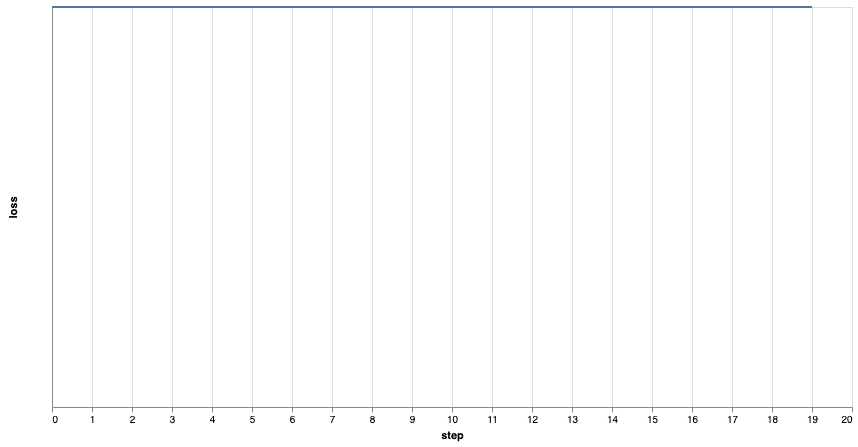

In [112]:
#!pip install altair
import altair as alt
import pandas

batch_loss = []
for i,l in enumerate(train_losses):
    batch_loss.append((i,l))

df = pandas.DataFrame(batch_loss, columns=['step', 'loss'])

alt.Chart(df).mark_line().encode(
    alt.X('step', scale=alt.Scale()),
    alt.Y('loss', scale=alt.Scale(type='log'))).properties(
        width=800,
        height=400
    )

## Analysis & Examples

## Compare N-gram LM to Neural LM

## Using FastText

## Using KenLM

In [16]:
out = vocab.FastText(language='en')

.vector_cache/wiki.en.vec:  19%|█▉        | 1.25G/6.60G [11:49<50:35, 1.76MB/s]


KeyboardInterrupt: 

In [ ]:
text_field.build_vocab(dataset, max_size=30000, vectors=out)

In [ ]:
# making a batch iterator
train_loader = data.BucketIterator(dataset=dataset, batch_size=4, sort_key=lambda x: len(x.reviewText), device=torch.device('cpu'), sort_within_batch=True, repeat=False)

In [ ]:
batch = next(iter(train_loader))
print(batch)

In [ ]:
def _vec2txt(vec):
    return [text_field.vocab.itos[t] for t in vec]

In [ ]:
print(batch.reviewText[0][0])
print(_vec2txt(batch.reviewText[0][0]))